In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060'

In [4]:
torch.cuda.device_count()

1

In [6]:
#데이터 셋 불러오기

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",   #학습/테스트 데이터가 저장되는 경로
    train=True,    #학습용/테스트용 데이터셋 여부를 지정
    download = True,   #root에 데이터가 없는경우 인터넷에서 다운로드
    transform=ToTensor()   #transform과 target_transform은 특징(feature)과 정답(label) 변형(transform)을 지정합니다. 
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



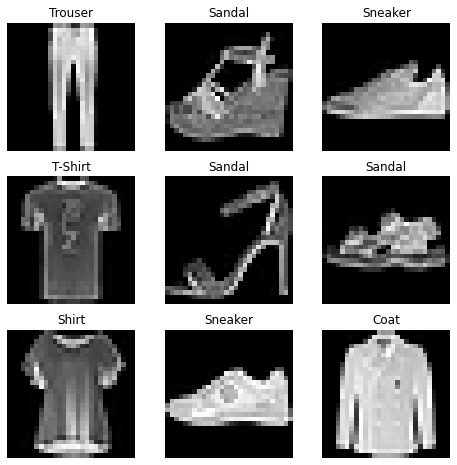

In [7]:
#데이터 셋을 순회하고 시각화하기
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))   #최초 창의 크기를 가로세로 8인치로 설정
cols, rows = 3, 3
for i in  range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()   #주어진 범위 내의 정수를 균등하게 생성, 자료형은 torch.foat32. item()텐서에서 값만 가져온다.
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") #squeeze() 1인 차원을 제거한다. 
plt.show()

In [24]:
#파일에서 사용자 정의 데이터셋 만들기
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    #__init__ : Dataset 객체가 생성될때 한번만 실행, 이미지와 주석파일(annotation_file)이 포함된 디렉토리와 두가지 변형을 초기화
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None): 
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    #__len__ 데이터셋의샘플 개수를 반환
    def __len__(self):
        return len(self.img_labels)

    #__getitem__ 주어진 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다. 인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고,
    #read_image를 사용하여 이미지를 텐서로 반환하고, self.img_labels의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우)
    #변형(trnasform)함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python사전(dict)형으로 반환한다. 
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [25]:
#DataLoader로 학습용 데이터 준비하기

#Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 모델을 학습할때, 일반적으로 샘플
#"미니배치(minibatch)"로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, python의 multiprocessing을 사용하여
#데이터 검색 속도를 높이려고 합니다. 

#DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회가능한 객체이다. 
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle=True)
tst_dataloader = DataLoader(test_data, batch_size=64, shuffle = True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


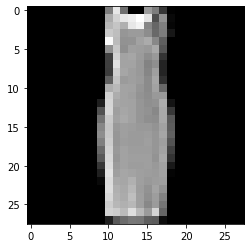

Label: 3


In [26]:
#DataLoader를 통해 순회하기(iteration)

#DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 아래의 각 순회(iteration)는 (각각 batch_size=64의
#특징(feature)과 정답(label)을 포함하는) train_features와 train_labels의 묶음(batch)을 반환합니다. shuffle=True로 지정했으므로, 모든 배치를
#순회한 뒤 데이터가 섞입니다. (데이터 불러오기 순서를 보다 세밀하게 (finer-grained)제어하려면 samplers를 살펴보세요)

# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")